In [1]:
import pandas as pd
import numpy as np
import os 
from src.batch_corrector import BatchCorrector
from src.processing_helpers import *
from src.processing_pipeline import*
from sklearn.decomposition import PCA

DATA_PATH = 'data/input'

# Data processing

In [2]:

paths = [os.path.join(DATA_PATH, f) for f in ['internship_data_matrix.csv', 'internship_acquisition_list.csv']]

data_loader = DataLoader(paths)
pipeline = Pipeline()

batch_corrector = BatchCorrector()
batch_corrector.min_detection_rate = 0.7
batch_corrector.frac_loess = 0.38
batch_corrector.sample_classes = ['Dunn', 'French', 'LMU']

data_filter = PipelineStep(name='Filter batch & classes',\
                        func=lambda data, verbose: filter_types(data, {'class': ['Dunn', 'French', 'LMU', 'QC'], 'batch': [1]}, verbose=verbose))
final_filter = PipelineStep(name='Filter classes',
                         func=lambda data, verbose: filter_types(data, {'class': ['Dunn', 'French', 'LMU']}, verbose=verbose))

visualizer = PipelineStep(name='PCA projection',
                          func = pca)
filters = PipelineMultiStep(name='Features filters',\
                            func=[filter_features_detection, filter_features_variability,
                                 lambda data, verbose : filter_features_dratio(data, sample_classes=['Dunn', 'French', 'LMU'], verbose=verbose)])
scaler = PipelineStep(name='StandardScaler',
                      func=normalize)
spliter = PipelineStep(name='Train-Test split',
                     func=split_train_test)


pipeline.add([data_loader, data_filter, batch_corrector, visualizer, filters, scaler, final_filter, spliter])


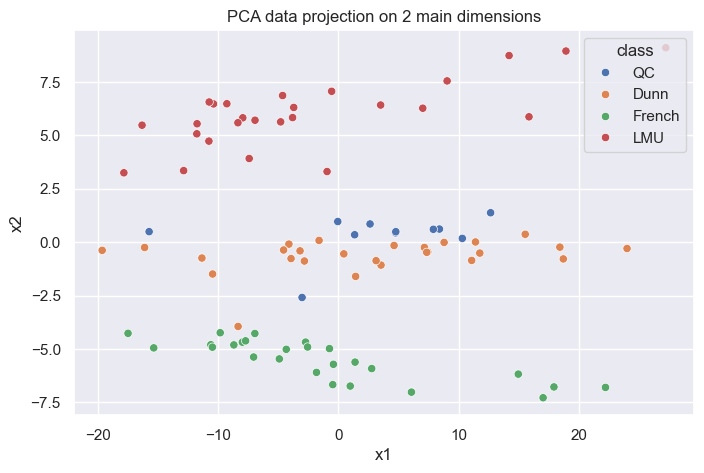

In [3]:
x_tr, x_test, y_tr, y_test, class_map, features = pipeline.run(verbose=False)

# Data classification

c:\Users\Philippine\Documents\Job search\Isospec\isospec-internship\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Best parameters found: {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 10}
Model scoring: 1.0


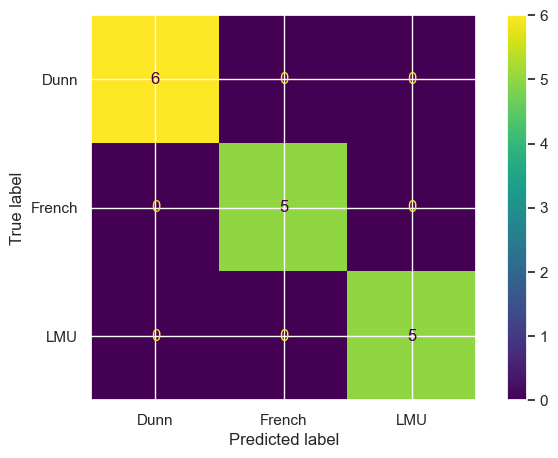

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from src.model_training import ModelTrainer, ShapWrapper, plot_feature_importance
import random

random.seed(42)

classifier = RandomForestClassifier(random_state=random.seed(42))
param_grid = {"n_estimators" : [5, 10, 15, 20, 25, 30],
              "max_depth": [3],
              "max_features": ['sqrt'],
              "bootstrap": [True]
              }

trainer = ModelTrainer(classifier, param_grid=param_grid)
trainer.cv = 3
trainer.tune_model(x_tr, y_tr, score='balanced_accuracy')
trainer.train_model(x_tr, y_tr)

trainer.evaluate_model(x_test, y_test, metrics=accuracy_score)
y_pred = trainer.best_model.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[v for _, v in class_map.items()])
disp.plot()


# Best features identification

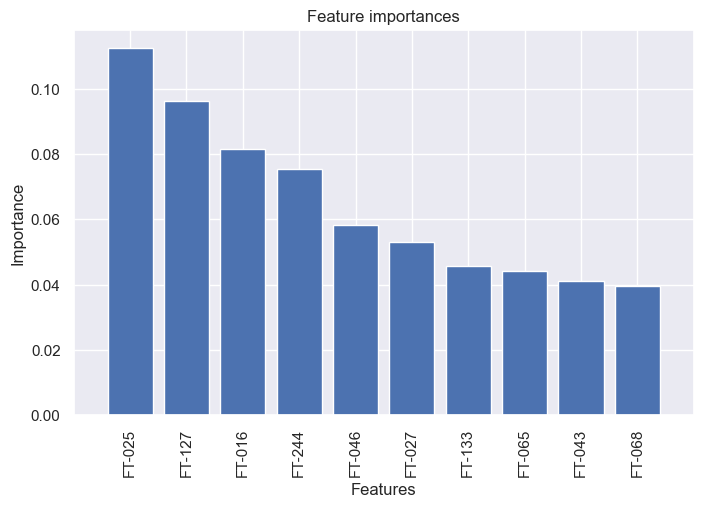

In [6]:
top_feats = plot_feature_importance(trainer.best_model, features)

C:\Users\Philippine\AppData\Local\Temp\ipykernel_18996\1539429923.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig.text(point[0]+.03, point[1], str(i)[:15] + '...')


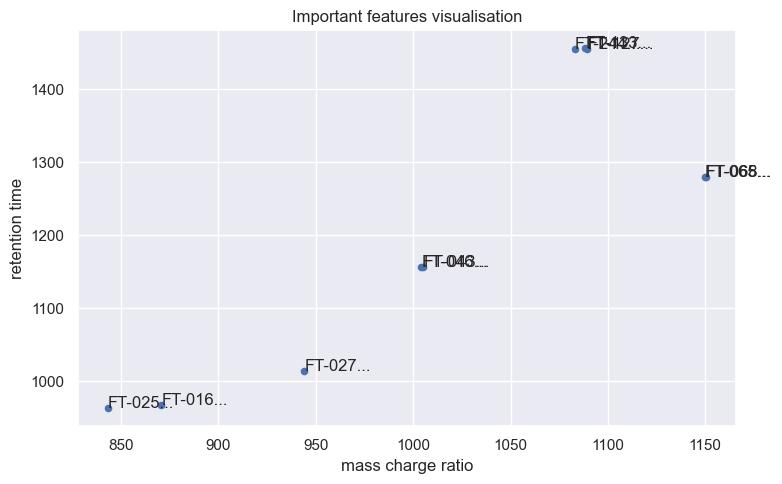

In [18]:
df_feature_meta = pd.read_csv(os.path.join('data/input', 'internship_feature_metadata.csv'))

top_feats_meta = df_feature_meta[df_feature_meta['feature'].isin(top_feats)][['mz', 'rt', 'feature']]
fig = top_feats_meta.plot.scatter(x='mz', y='rt')

for i, point in top_feats_meta.set_index('feature').iterrows():
    fig.text(point[0]+.03, point[1], str(i)[:15] + '...')

plt.xlabel('mass charge ratio')
plt.ylabel('retention time')
plt.title('Important features visualisation')
plt.tight_layout()

In [ ]:
shap_explainer = ShapWrapper(trainer.best_model, X_train=x_tr)